# Light Curve Classifier
***

## Learning Goals
By the end of this tutorial, you will be able to:
- do some basic data cleaning and filtering to prepare the data for the ML algorithms
- work with Pandas data frames as a way of storing time domain datasets
- use sktime algorithms to train a classifier and predict values on a test dataset

## Introduction
This notebook takes output of a previous demo notebook which generates light curves from archival data, does data prep, and runs the light curves through multiple [`sktime`](https://www.sktime.net/en/stable/) classifiers.  The goal of the classifiers is to be able to differentiate changing look active galactic nucleii (CLAGN) from an SDSS quasar sample based on multiband light curves.  CLAGN are quite interested objects in that they appear to change state, but only a few hundred are currently known, and finding them is quite expensive requiring spectroscopic follow up.  Being able to identify CLAGN in existing large samples would allow us to identify a statisitcal sample from which we could better understand the physics of what is occuring in these systems.

The challenges of this time-domain dataset are:
1. Multi-variate = There are multiple bands of observations per target (13+)
2. Unequal length = Each band has a light curve with different sampling than other bands
3. Missing data = Not each object has all observations in all bands

We choose to use a Pandas multiindex dataframe to store and work with the data because it fulfills these requirements:
1. It can handle the above challenges of a dataset = multi-variate, unqueal length with missing data.
2. Multiple targets (multiple rows)
3. Pandas has some built in understanding of time units
4. Can be scaled up to big data numbers of rows (altough we don't push to out of memory structures in this use case)
5. Pandas is user friendly


## Input
Light curve parquet file of multiband light curves from the mulitband_lc.ipynb demo notebook.  The format of the light curves is a Pandas multiindex data frame

A useful reference for what sktime expects as input to its ML algorithms: https://github.com/sktime/sktime/blob/main/examples/AA_datatypes_and_datasets.ipynb

## Output
Trained classifiers as well as estimates of their accuracy and plots of confusion matrices

## Imports
- `pandas` to work with light curve data structure
- `numpy` for numerical calculations
- `matplotlib` for plotting
- `sys` for paths
- `astropy` to work with coordinates/units and data structures
- `tqdm` for showing progress meter
- `sktime` ML algorithms specifically for time-domain data
- `sklearn` general use ML algorthims with easy to use interface

## Authors

## Acknowledgements

In [ ]:
#ensure all dependencies are installed
!pip install -r requirements-lc_classifier.txt

In [ ]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astropy.time import Time
from google_drive_downloader import GoogleDriveDownloader as gdd
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sktime.classification.deep_learning import CNNClassifier
from sktime.classification.dictionary_based import IndividualTDE
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier
from sktime.classification.dummy import DummyClassifier
from sktime.classification.ensemble import WeightedEnsembleClassifier
from sktime.classification.feature_based import Catch22Classifier, RandomIntervalClassifier
from sktime.classification.hybrid import HIVECOTEV2
from sktime.classification.interval_based import CanonicalIntervalForest
from sktime.classification.kernel_based import Arsenal, RocketClassifier
from sktime.classification.shapelet_based import ShapeletTransformClassifier
from sktime.registry import all_estimators, all_tags
from tqdm import tqdm

# local code imports
sys.path.append('code_src/')
from fluxconversions import mjd_to_jd

## 1. Read in a dataset of archival light curves

In [20]:
#access structure of light curves made in the light curve notebook
# has CLAGN & SDSS small sample, all bands
#https://drive.google.com/file/d/13RiPODiz2kI8j1OKpP1vfh6ByIUNsKEz/view?usp=share_link

gdd.download_file_from_google_drive(file_id='13RiPODiz2kI8j1OKpP1vfh6ByIUNsKEz',
                                    dest_path='./data/df_lc_458sample.parquet',
                                    unzip=True)

df_lc = pd.read_parquet("./data/df_lc_458sample.parquet")

#get rid of indices set in the light curve code and reset them as needed before sktime algorithms
df_lc = df_lc.reset_index()  

## 2. Data Prep
This dataset needs significant work before it can be fed into a ML algorithm

In [21]:
#what does the dataset look like anyway?
df_lc

,objectid,label,band,time,flux,err
0,112,Lopez-Navas 22,FERMIGTRIG,56371.813768,0.100000,0.100000
1,218,SDSS,FERMIGTRIG,59568.171278,0.100000,0.100000
2,395,SDSS,FERMIGTRIG,54699.331556,0.100000,0.100000
3,414,SDSS,FERMIGTRIG,56369.455916,0.100000,0.100000
4,434,SDSS,FERMIGTRIG,58941.402522,0.100000,0.100000
...,...,...,...,...,...,...
426627,183,SDSS,w2,55230.410156,6.717855,0.019561
426628,183,SDSS,w2,57054.886719,6.715584,0.023281
426629,183,SDSS,w2,57247.308594,7.572342,0.024136
426630,183,SDSS,w2,57977.214844,7.876407,0.023734


### 2.1 Remove bands with not enough data

In [22]:
##what are the unique set of bands included in our light curves
df_lc.band.unique()

array(['FERMIGTRIG', 'IceCube', 'zg', 'zr', 'zi', 'panstarrs i',
       'panstarrs y', 'panstarrs z', 'panstarrs g', 'panstarrs r',
       'Gaia g', 'Gaia bp', 'Gaia rp', 'K2', 'TESS', 'w1', 'w2'],
      dtype=object)

In [23]:
## get rid of some of the bands that don't have enough data for all the sources
bands_to_drop = ["IceCube", "TESS", "FERMIGTRIG", "K2"]
df_lc = df_lc[~df_lc["band"].isin(bands_to_drop)]


### 2.2 Combine Labels for a Simpler Classification
All CLAGN start in the dataset as having labels based on their discovery paper.  Because we want one sample with all known CLAGN, change those discoery names to be simply "CLAGN" for all CLAGN, regardless of origin

In [24]:

df_lc['label'] = df_lc.label.str.replace('MacLeod 16', 'CLAGN')
df_lc['label'] = df_lc.label.str.replace('LaMassa 15', 'CLAGN')
df_lc['label'] = df_lc.label.str.replace('Yang 18', 'CLAGN')
df_lc['label'] = df_lc.label.str.replace('Lyu 21', 'CLAGN')
df_lc['label'] = df_lc.label.str.replace('Hon 22', 'CLAGN')
df_lc['label'] = df_lc.label.str.replace('Sheng 20', 'CLAGN')
df_lc['label'] = df_lc.label.str.replace('MacLeod 19', 'CLAGN')
df_lc['label'] = df_lc.label.str.replace('Green 22', 'CLAGN')
df_lc['label'] = df_lc.label.str.replace('Lopez-Navas 22', 'CLAGN')



/tmp/ipykernel_1931/2260488855.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lc['label'] = df_lc.label.str.replace('MacLeod 16', 'CLAGN')
/tmp/ipykernel_1931/2260488855.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lc['label'] = df_lc.label.str.replace('LaMassa 15', 'CLAGN')
/tmp/ipykernel_1931/2260488855.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

### 2.3 Remove some rows based on filtering out bad data

In [25]:
#find and drop bad rows

#one panstarrs z has a crazy err value of -999000, definitely don't want to include that one
querystring = 'err < -100'
df_lc = df_lc.drop(df_lc.query(querystring).index)

#drop rows which have Nans
df_lc.dropna(inplace = True, axis = 0)

#drop ~8 rows with zero flux
querystring = 'flux < 0.000001'
df_lc = df_lc.drop(df_lc.query(querystring).index)



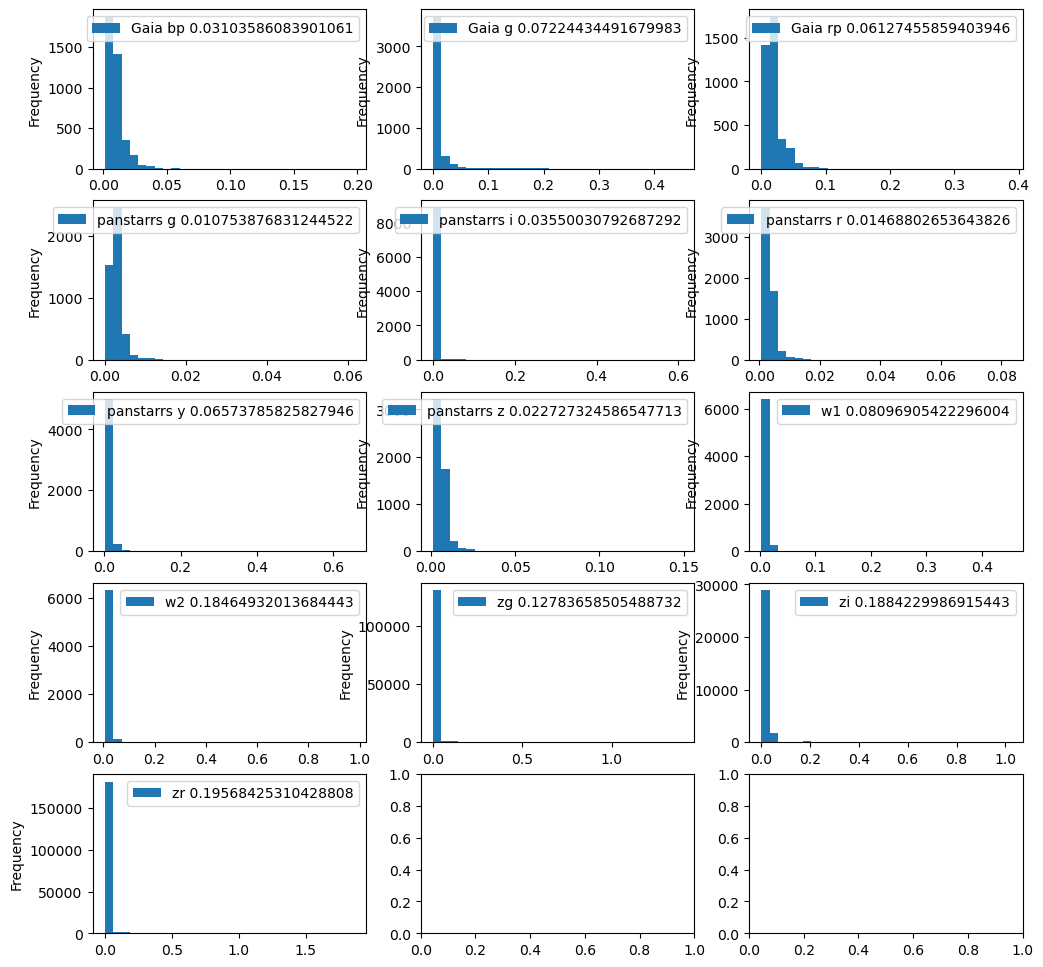

In [26]:
#consider Removing all rows with errors outside of a normal distribution
#plot histograms in flux units to see what these distributions look like

band_list = df_lc.band.unique()
threesigmaonmean= {}

#create the figure and axes
fig, axs = plt.subplots(5, 3, figsize = (12, 12))

# unpack all the axes subplots
axe = axs.ravel()

#for each band
for count, (bandname, singleband) in enumerate(df_lc.groupby("band")):
    cut = singleband['err'].mean() + 3 * (singleband['err'].std())
    threesigmaonmean[bandname] = cut
    #plot distributions and print stddev
    singleband['err'].plot(kind = 'hist', bins = 30, subplots =True, ax = axe[count],label = bandname+' '+str(cut), legend=True)



In [27]:
#3sigma looks by eye like a reasonable cut for all distributions
#make it so
for bandname, cut in threesigmaonmean.items():
    querystring = f'band == {bandname!r} & err > {cut}'
    print(querystring)
    df_lc = df_lc.drop(df_lc.query(querystring).index)

band == 'Gaia bp' & err > 0.03103586083901061
band == 'Gaia g' & err > 0.07224434491679983
band == 'Gaia rp' & err > 0.06127455859403946
band == 'panstarrs g' & err > 0.010753876831244522
band == 'panstarrs i' & err > 0.03550030792687292
band == 'panstarrs r' & err > 0.01468802653643826
band == 'panstarrs y' & err > 0.06573785825827946
band == 'panstarrs z' & err > 0.022727324586547713
band == 'w1' & err > 0.08096905422296004
band == 'w2' & err > 0.18464932013684443
band == 'zg' & err > 0.12783658505488732
band == 'zi' & err > 0.1884229986915443
band == 'zr' & err > 0.19568425310428808


In [28]:
#this removed ~2% of the rows, which is reasonable and we haven't done anything drastic
df_lc


,objectid,label,band,time,flux,err
1379,92,CLAGN,zg,58202.309236,0.736736,0.010347
1380,92,CLAGN,zg,58202.314560,0.730595,0.010290
1381,92,CLAGN,zg,58205.302651,0.658396,0.009634
1382,92,CLAGN,zg,58205.320949,0.681111,0.009840
1383,92,CLAGN,zg,58208.357257,0.589205,0.009014
...,...,...,...,...,...,...
426627,183,SDSS,w2,55230.410156,6.717855,0.019561
426628,183,SDSS,w2,57054.886719,6.715584,0.023281
426629,183,SDSS,w2,57247.308594,7.572342,0.024136
426630,183,SDSS,w2,57977.214844,7.876407,0.023734


### 2.4 What to do with missing data?
Some objects do not have light curves in all bands, what do we do about that?  Some ML algorithms can handle mising data, but not all. 

Some objects have only a few datapoints.  Three data points is not a large enough for outlier rejection, so we will consider any array with fewer than 4 photometry points to be missing data.

Decide to add light curves with zero flux and err values for the missing data.  SKtime does not like NaNs

**may want to reconsider this one day

In [50]:
def make_zero_df(oid, band, label):
    timelist = [55230,57054, 57247, 57977, 58707]  #making this up for now from some WISE times
    dfsingle = pd.DataFrame(dict(flux=np.zeros(len(timelist)), err=np.zeros(len(timelist)), 
                                 time=timelist, objectid=np.repeat(oid, len(timelist)), 
                                 band=np.repeat(band, len(timelist)),label=np.repeat(label, len(timelist))))


    return dfsingle


In [51]:
#what is the full set of unique band names?
full_bandname = df_lc.band.unique()

#for the case where there is no photometry in a band:
#for each object in each band
for oid , singleoid in df_lc.groupby("objectid"):
                                  
    #this is the list of bandnames for that object                                
    oid_bandname = singleoid.band.unique()
    
    #figure out which bands are missing
    missing = list(set(full_bandname).difference(oid_bandname))
    
    #if it is not the complete list, ie some bandnames are missing:                            
    if len(missing) > 0:
    
        #make new dataframe for this object with zero flux and err values
        for m in range(len(missing)):
            label = singleoid.label.unique()
            dfsingle = make_zero_df(oid, missing[m], label)
            
            #now concatenate the single new df with df_lc
            df_lc = pd.concat([df_lc, dfsingle])

            
#and now for the case that the band is there but has too few datapoints:
thresh_too_few = 4
for (band,oid) , singleband_oid in df_lc.groupby(["band", "objectid"]):
    #if there are less than 4 photometry points
    if len(singleband_oid.time) < thresh_too_few:
        label = singleband_oid.label.unique()
        df_lc = make_zero_df(oid, band, label)
        

oid 2 band Gaia g label CLAGN
oid 2 band Gaia bp label CLAGN
oid 2 band Gaia rp label CLAGN
oid 3 band Gaia bp label CLAGN
oid 3 band zg label CLAGN
oid 3 band zi label CLAGN
oid 3 band Gaia g label CLAGN
oid 3 band Gaia rp label CLAGN
oid 7 band zi label CLAGN
oid 8 band Gaia g label CLAGN
oid 8 band Gaia bp label CLAGN
oid 8 band Gaia rp label CLAGN
oid 10 band zi label CLAGN
oid 12 band zi label CLAGN
oid 13 band Gaia bp label CLAGN
oid 13 band zi label CLAGN
oid 13 band Gaia g label CLAGN
oid 13 band Gaia rp label CLAGN
oid 14 band zi label CLAGN
oid 16 band zg label CLAGN
oid 16 band zi label CLAGN
oid 18 band zi label CLAGN
oid 22 band zg label CLAGN
oid 22 band zi label CLAGN
oid 24 band zi label CLAGN
oid 28 band zi label CLAGN
oid 30 band zg label CLAGN
oid 33 band zi label CLAGN
oid 35 band Gaia g label CLAGN
oid 35 band Gaia bp label CLAGN
oid 35 band Gaia rp label CLAGN
oid 37 band zi label CLAGN
oid 39 band Gaia g label CLAGN
oid 39 band Gaia bp label CLAGN
oid 39 band Gai

### 2.5 Make a new time column with datetime data type 
We need the times in python [datetime](https://docs.python.org/3/library/datetime.html) format for the next section where we will make the light curves be of uniform length. 

Once the time column is in datetime format, make it the time index

In [ ]:
#need to convert df_lc time into datetime
mjd = df_lc.time

#convert to JD
jd = mjd_to_jd(mjd)

#convert to individual components
t = Time(jd, format = 'jd' )

#t.datetime is now an array of type datetime
#make it a column in the dataframe
df_lc['datetime'] = t.datetime



### 2.5  Make all objects and bands have identical time arrays (uniform length and spacing)

It is very hard to find time-domain ML algorithms which can handle non uniform length datasets. Therefore we make them uniform using Pandas [reindex](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.reindex.html) which fills in the uniform length arrays with values according to the method chosen by the user.  We implement a nearest neighbor to fill the arrays.  

Fluxes with missing data are set to zero.  Zero was chosen instead of 'None' or 'Nan' as it was better integrated with the ML algorithms.  

Potential other options for uniformizing the time series dataset:
- pandas.dataframe.interpolate with many methods

In [ ]:
df_lc

what is going on here? 1 Gaia bp 0 [0.04600922]
what is going on here? 1 Gaia bp 5 [0.06403799]
what is going on here? 1 Gaia bp 6 [0.09159492]
what is going on here? 1 Gaia bp 10 [0.06700473]
what is going on here? 1 Gaia bp 11 [0.02157747]
what is going on here? 1 Gaia bp 15 [0.06066044]
what is going on here? 1 Gaia bp 16 [0.05251225]
what is going on here? 1 Gaia bp 17 [0.04302511]
what is going on here? 1 Gaia bp 18 [0.03922708]
what is going on here? 1 Gaia bp 19 [0.08454342]
what is going on here? 1 Gaia bp 20 [0.06119788]
what is going on here? 1 Gaia bp 21 [0.03552831]
what is going on here? 1 Gaia bp 22 [0.02850275]
what is going on here? 1 Gaia bp 24 [0.0200263]
what is going on here? 1 Gaia bp 25 [0.03945362]
what is going on here? 1 Gaia bp 26 [0.05771193]
what is going on here? 1 Gaia bp 27 [0.02304065]
what is going on here? 1 Gaia bp 28 [0.09108673]
what is going on here? 1 Gaia bp 29 [0.08482638]
what is going on here? 1 Gaia bp 30 [0.13537095]
what is going on here? 1

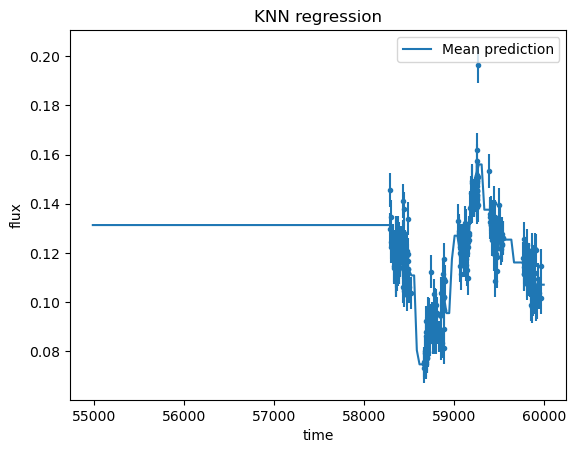

In [19]:
%%time
#try a sklearn regressor to fit the shape of the light curve and do interpolation
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.neighbors import KNeighborsRegressor


#make a time array with the minimum and maximum of all light curves in the sample
final_freq_int = 30  #this is the timescale of interpolation
x_interpol = np.arange(df_lc.time.min(), df_lc.time.max(), final_freq_int)
x_interpol = x_interpol.reshape(-1, 1) # needed for sklearn

#look at each object in each band
for (band,oid) , singleband_oid in df_lc.groupby(["band", "objectid"]):
    #singleband_oid is now a dataframe with just one object and one band
    
    X = np.array(singleband_oid["time"]).reshape(-1, 1)
    y = np.array(singleband_oid["flux"])
    dy = np.array(singleband_oid["err"])
    
    if len(X) < 5:
        print("what is going on here?", len(X), band, oid, y)
    if len(X) > 4:
        #kernel = 1.0 * RBF(length_scale=30)
        #gp = GaussianProcessRegressor(kernel=kernel, alpha=dy**2, normalize_y = False)
        #gp.fit(X, y)
        #mean_prediction,std_prediction = gp.predict(x_interpol, return_std=True)

        #try KNN
        KNN = KNeighborsRegressor(n_neighbors = 5)
        KNN.fit(X, y)
        mean_prediction = KNN.predict(x_interpol)
        #testing on just a single light curve for now
        if (band == 'zr') and (oid == 1) :  
            #see if this looks reasonable
            plt.errorbar(X,y,dy,linestyle="None",color="tab:blue",marker=".")
            plt.plot(x_interpol, mean_prediction, label="Mean prediction")
            #plt.fill_between(
            #    x_interpol.ravel(),
            #    mean_prediction - 1.96 * std_prediction,
            #    mean_prediction + 1.96 * std_prediction,
            #    color="tab:orange",
            #    alpha=0.5,
            #    label=r"95% confidence interval",
            #)
            plt.legend()
            plt.xlabel("time")
            plt.ylabel("flux")
            _ = plt.title("KNN regression")

In [ ]:
#reset the index to make this section work
df_lc = df_lc.set_index(["objectid", "label", "band", "datetime"])

In [ ]:
df_lc

In [ ]:
def reindex_lc(df_lc, final_freq = '30D'):

    '''
    make the time arrays have uniform length and spacing by interpolating the fluxes using pandas.reindex
    This function is a mess and needs a good workthrough to remove indices from multiiindex dataframe and clean up
    the flow, but it might also get deleted, so leaving it as is for now.
    
    Parameters
    ----------
    df_lc: multiIndexDFObject
    final_freq: str
        frequency of time sampling to choose for the reindex
        '30D' is 30 days

    Returns
    --------
    MultiIndexDFObject  
    '''

    #make a new index with the full range of datetimes and a specified frequency
    final_freq = '30D'
    fullindex = pd.date_range(start=df_lc.droplevel('objectid').droplevel('label').droplevel('band').index.min(), end=df_lc.droplevel('objectid').droplevel('label').droplevel('band').index.max(), freq=final_freq)

    #what is the full set of unique band names?
    full_bandname = df_lc.index.unique('band').tolist()

    #setup to hold the resulting dataframe
    df_reindex = pd.DataFrame()

    #how many objects are in the dataframe?
    #actually this is the max and some of them are missing
    nobj = df_lc.index.unique('objectid').max() + 1

    #for each objct in the dataframe
    for oid in tqdm(range(nobj)):
        try:
            oid_bandname = df_lc.loc[oid,:,:,:].index.unique('band').tolist()
        except KeyError:
            #some of the data cleaning above must have removed some objects
            print(oid, ' objectid doesnt exist')
            continue
            
        #this is the case where the objectid exists, so let's make sure all the bands are there
        oid_label = df_lc.loc[oid,:,:,:].index.unique('label').tolist()
    
        #if bandname for this oid is not equal to the full list
        #If there are missing bands for this object
        if oid_bandname != full_bandname:
    
            #figure out which bands are missing
            missing = list(set(full_bandname).difference(oid_bandname))
        
            #make new dataframe for this object with NaN flux and err values
            #choosing random times for now that will get fleshed out when I reindex all times below
            for m in range(len(missing)):
                datetimelist = [pd.to_datetime(1490195805, unit='s'), pd.to_datetime(1491195805, unit='s')]  #making this up for now
                dfsingle = pd.DataFrame(dict(flux=np.zeros(2), err=np.zeros(2), datetime=datetimelist, objectid=oid, band=missing[m],label=oid_label[0])).set_index(["objectid","label", "band", "datetime"])        

                #now concatenate the single new df with df_lc
                df_lc = pd.concat([df_lc, dfsingle])
            
        #for each band
        for bandid in range(len(full_bandname)):
    
            #set up to only have time as an index
            single_obj = df_lc.loc[oid,:,full_bandname[bandid],:].reset_index().set_index('datetime')
    
            #sort the time index
            single_obj = single_obj.sort_index()
    
            #change the time index to have values in fullindex, and use 'nearest' to fill
            #in values of the new time indices
            #this is where the real work gets done
            single_reindex = single_obj.reindex(fullindex, method = 'nearest')
    
            #previous command returns an unnamed index, so name it
            single_reindex.index.rename('datetime', inplace= True)
    
            #then we really want a multiindex df, so first remove indices, then set the ones we want
            single_reindex.reset_index(inplace= True)
            
            #put oid and bandname back into the dataframe
            single_reindex['objectid'] = oid
            single_reindex['band'] = full_bandname[bandid]
            
            #re-make index
            single_reindex.set_index(["objectid" ,"label","band", "datetime"], inplace = True)
    
            #concatenate all the dfs together
            if df_reindex.empty: 
                df_reindex = single_reindex
            else:
                df_reindex = pd.concat([df_reindex, single_reindex])
                
    return df_reindex

In [ ]:
%%time
#This cell takes about ~13 min to run depending on your server
df_reindex = reindex_lc(df_lc)

In [ ]:
df_reindex

In [ ]:
#proove this did what I wanted it to do
oid = 0
#how many bandnames in object 0?
bn = df_lc.loc[oid,:,:,:].index.unique('band').tolist()
print('there are', bn, 'bandnames ')
#how many times per band in object 0
oid_bandname = df_reindex.loc[oid,:,:,:].index.unique('band').tolist()
for i in range(len(oid_bandname) ):
    times = df_reindex.loc[oid,:,oid_bandname[i],:].index.unique('datetime').tolist()
    print('for band', oid_bandname[i],' there are ', len(times),' times')
    
    
#output from this cell should show that all bands have the same length

In [ ]:
#figure out if this 'nearest' reindexing is a reasonable choice for this use case
#plotting the light curves before and after reindexing.

#pick one object, one band for now
dfsingle_before = df_lc.loc[4,:,'panstarrs r',:]
dfsingle_after = df_reindex.loc[4,:,'panstarrs r',:]

#time in a format matplotlib can handle
t1 = dfsingle_before.index.get_level_values('datetime').to_pydatetime()
f1 = dfsingle_before.flux

fig, ax = plt.subplots(figsize=(10,6))
f = ax.plot(t1, f1, label = "original") 
f = ax.scatter(t1, f1, label = "original")

t2 = dfsingle_after.index.get_level_values('datetime').to_pydatetime()
f2 = dfsingle_after.flux
f = ax.plot(t2, f2, label = "reindexed") 
ax.legend()



In [ ]:
#what does the dataframe currently look like
df_reindex

### 2.6  Restructure dataframe in format expected by sktime
- Make columns have band names in them and then remove band from the index
- pivot the dataframe so that SKTIME understands its format

In [ ]:
pivoted_df_reindex = df_reindex.reset_index(level="band").pivot(columns="band")
pivoted_df_reindex.columns = ["_".join(col) for col in pivoted_df_reindex.columns.values]

In [ ]:
pivoted_df_reindex

### 2.7 Normalize to the mean of each objectid
- this is normalizing across all bands
- think this is the right place to do this, rather than before we reindex over time 
    so that the final light curves are normalized since that is the chunk of information 
    which goes into the ML algorithms.
- chose mean and not median because there are some objects where the median flux = 0.0
    - if we did this before the reindexing, the median might be a non-zero value
- normalizing is required so that the CLAGN and it's comparison SDSS sample don't have different flux levels.


Idea here is that we normalize across each object.  So the algorithms will know for example that within one object W1 will be brighter than ZTF bands but from one object to the next, it will not know that one is brighter than the other.

In [ ]:
# make a new column with max_r_flux for each objectid
pivoted_df_reindex['max_zr'] = pivoted_df_reindex.groupby('objectid', sort=False)["flux_zr"].transform('max')

#figure out which columns in the dataframe are flux columns
flux_cols = [col for col in pivoted_df_reindex.columns if 'flux' in col]

# make new normalized flux columns for all fluxes
pivoted_df_reinde[flux_cols] = pivoted_df_reinde[flux_cols].div(pivoted_df_reinde['max_zr'], axis=0)

### 2.8 Save this dataframe

In [ ]:
#save this dataframe to use for the ML below so we don't have to make it every time
parquet_savename = 'output/df_ML_091523.parquet'
pivoted_df_reindex.to_parquet(parquet_savename)
#print("file saved!")

In [ ]:
# could load a previously saved file in order to plot
#parquet_loadname = 'output/df_ML_091523.parquet'
#pivoted_df_reindex = MultiIndexDFObject()
#pivoted_df_reindex.data = pd.read_parquet(parquet_loadname)
#print("file loaded!")

## 3. Prep for ML algorithms in sktime



### 3.0 Consider data augmentation

1. https://arxiv.org/pdf/1811.08295.pdf which has the following github

    - https://github.com/gioramponi/GAN_Time_Series/tree/master
    - not easily usable
2. https://arxiv.org/pdf/2205.06758.pdf

3. ChatGPT - give multiindex df function and it will give a starting point for augmenting


Worried that augmenting noisy data just makes more noise


### 3.1 Train test split 
- Because thre are uneven numbers of each type (many more SDSS than CLAGN), we want to make sure to stratify evenly by type
- Random split


In [ ]:
#y is defined to be the labels
y = pivoted_df_reindex.droplevel('datetime').index.unique().get_level_values('label').to_series()

#want a stratified split based on label
train_ix, test_ix = train_test_split(pivoted_df_reindex.index.levels[0], stratify = y, shuffle = True, random_state = 43, test_size = 0.25)

train_df = pivoted_df_reindex.loc[train_ix]  
test_df = pivoted_df_reindex.loc[test_ix]   


In [ ]:
#what does it look like?
train_df

In [ ]:
#plot to show how many of each type of object in the test dataset

plt.figure(figsize=(6,4))
plt.title("Objects in the Test dataset")
h = plt.hist(test_df.droplevel('datetime').index.unique().get_level_values('label').to_series(),histtype='stepfilled',orientation='horizontal')


### 3.2 Convert df_lc into X and y

In [ ]:
#divide the dataframe into X and y for ML algorithms 

#X is the multiindex light curve without the labels
X_train  = train_df.droplevel('label')
X_test = test_df.droplevel('label')

#y are the labels, should be a series 
y_train = train_df.droplevel('datetime').index.unique().get_level_values('label').to_series()
y_test = test_df.droplevel('datetime').index.unique().get_level_values('label').to_series()



### 3.3 Check that the data types are ok for sktime

In [ ]:
#ask sktime if it likes the data type of X
from sktime.datatypes import check_is_mtype

check_is_mtype(X_train, mtype="pd-multiindex", scitype="Panel", return_metadata=True)
#check_is_mtype(X_test, mtype="pd-multiindex", scitype="Panel", return_metadata=True)

## 4. Run Machine Learning Algorithms on the light curves

We choose to use [sktime](https://www.sktime.net/en/stable/index.html) algorithms beacuse it is a library of many algorithms specifically tailored to time series datasets.  It is based on the sklearn library so syntax is familiar to many users.

Types of classifiers are listed [here](https://www.sktime.net/en/stable/api_reference/classification.html).

This notebook will invert the actual workflow and show you a single example of the algorithm which best fits the data and has the most accurate classifier. Then it will show how to write a for loop over a bunch of classifiers before narrowing it down to the most accurate.



In [ ]:
#what is the list of all possible classifiers that work with multivariate data
#all_tags(estimator_types = 'classifier')
classifiers = all_estimators("classifier", filter_tags={'capability:multivariate':True})
classifiers


### 4.1 The Most Accurate Classifier
See section 4.2 for how we landed with this algorithm


In [ ]:
#looks like RandomIntervalClassifier is performing the best for the CLAGN (not for the SDSS)

#setup the classifier
clf = RandomIntervalClassifier(n_intervals = 20, n_jobs = -1, random_state = 43)

#fit the classifier on the training dataset
clf.fit(X_train, y_train)

#make predictions on the test dataset using the trained model 
y_pred = clf.predict(X_test)

print(f"Accuracy of Random Interval Classifier: {accuracy_score(y_test, y_pred)}\n", flush=True)

#plot a confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot()
    
plt.show()

### 4.2 Loop over a bunch of classifiers

Our method is to do a cursory check of a bunch of classifiers and then later drill down deeper on anything with good initial results.  We choose to run a loop over ~10 classifiers that seem promising and check the accuracy scores for each one.  Any classifier with a promising accuracy score could then be followed up with detailed hyperparameter tuning, or potentially with considering other classifiers in that same type.

In [ ]:
#which classifiers are we interestd in
#roughly one from each type of classifier

names = ["Arsenal",                     #kernel based
        "RocektClassifier",             #kernel based
        "CanonicalIntervalForest",      #interval based
        "HIVECOTEV2",                   #hybrid
#        "CNNClassifier",               #Deep Learning  - **requires tensorflow which is giving import errors
#        "WeightedEnsembleClassifier",   #Ensemble - **maybe use in the future if we find good options
        "IndividualTDE",               #Dictionary-based
        "KNeighborsTimeSeriesClassifier", #Distance Based
        "RandomIntervalClassifier",     #Feature based
        "Catch22Classifier",            #Feature based
        "ShapeletTransformClassifier"   #Shapelet based
        "DummyClassifier"]             #Dummy - ignores input

#for those with an impossible time limit, how long to let them run for before cutting off
nmins = 10

#these could certainly be more tailored
classifier_call = [Arsenal(time_limit_in_minutes=nmins, n_jobs = -1), 
                  RocketClassifier(num_kernels=2000),
                  CanonicalIntervalForest(n_jobs = -1),
                  HIVECOTEV2(time_limit_in_minutes=nmins, n_jobs = -1),
#                  CNNClassifier(),
#                  WeightedEnsembleClassifier(),
                  IndividualTDE(n_jobs=-1),
                  KNeighborsTimeSeriesClassifier(n_jobs = -1),
                  RandomIntervalClassifier(n_intervals = 20, n_jobs = -1, random_state = 43),
                  Catch22Classifier(outlier_norm = True, n_jobs = -1, random_state = 43),
                  ShapeletTransformClassifier(time_limit_in_minutes=nmins,n_jobs = -1),
                  DummyClassifier()]

#setup to store the accuracy scores
accscore_dict = {}

# iterate over classifiers
for name, clf in tqdm(zip(names, classifier_call)):
    #fit the classifier
    clf.fit(X_train, y_train)
    
    #make predictions on the test dataset
    y_pred = clf.predict(X_test)

    #calculate and track accuracy score
    accscore = accuracy_score(y_test, y_pred)
    print(f"Accuracy of {name} classifier: {accscore}\n", flush=True)
    accscore_dict[name] = accscore
    
    #plot confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
    disp.plot()
    plt.show()

#just for keeping track, I also tried 
#clf = SignatureClassifier(depth = 2, window_depth = 3, random_state = 43)
#this fails to complete, and is a known limitation of this algorithm.  

In [ ]:
#show the summary of the algorithms used and their accuracy score
accscore_dict

## 5.0 Conclusions:  
This classifier can be used to predict CLAGN.  The feature based algorithms do the best jobs of having little to no predicted CLAGN that are truly normal SDSS quasars.  We infer then that if the trained model predicts CLAGN, it is a very good target for follow-up spectroscopy to confirm CLAGN.  However this algorthim will not catch all CLAGN, and will incorrectly labels some CLAGN as being normal SDSS quasars.  THis algorithm can therefore not be used to find a complete sample of CLAGN, but can be used to increase the known sample.


### 5.1 Potential Areas of improvement
- Data is messy
    - ZTF calibration??
- Label inaccuracy is a concern
    - mostly SDSS, 
    - but CLAGN papers all have different selection criteria
- Not enough data on CLAGN
    - limited number of lightcurves
    - consider data augmentation